# Introduction

**Hello!**

In this project, we will look at
raw text in the form of movie reviews. The movie review content by critics coming from a dataset from Kaggle will be pre-processed, and analyzed using Multinomial Naive Bayes and Multilayer Perceptron, and how these textual
reviews justify the movie ratings will be studied. Features derived from textual reviews will be used
as input to predict their corresponding review ratings and categorize reviews as positive, neutral, or negative
as the output.

Let's first import the packages we'll need.

In [1]:
import numpy as np
import pandas as pd
import re
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
from collections import Counter
from sklearn.metrics import accuracy_score


import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from wordcloud import WordCloud

%pylab inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

# from google.colab import drive
# drive.mount('/content/drive', force_remount = True)
# %cd /content/drive/Shared drives/FreeRobux ML Project/code
%cd G:/Shared drives/FreeRobux ML Project/code
%ls

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
G:\Shared drives\FreeRobux ML Project\code


[nltk_data] Downloading package stopwords to C:\Users\ZANDREW
[nltk_data]     GARAIS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\ZANDREW GARAIS\AppData\Roaming\Python\Python312\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


 Volume in drive G is Google Drive
 Volume Serial Number is 1983-1116

 Directory of G:\Shared drives\FreeRobux ML Project\code

10 Jun 2024  13:22    <DIR>          .
08 May 2024  15:51    <DIR>          ..
07 Jun 2024  17:59         2,007,097 FreeRobux [GACHO, GARAIS].zip
07 Jun 2024  17:55             2,926 FreeRobux_Project_Application.ipynb
10 Jun 2024  13:25         2,624,849 FreeRobux_Project_Implementation.ipynb
07 Jun 2024  17:50        18,332,335 log_reg_model.joblib
07 Jun 2024  17:54             1,470 movie_review_site.py
10 Jun 2024  13:22        73,326,583 multinomial_nb_model.joblib
07 Jun 2024  17:49             2,283 README.md
07 Jun 2024  17:36                33 requirements.txt
04 Nov 2020  16:59       226,049,903 rotten_tomatoes_critic_reviews.csv
04 Nov 2020  16:59        17,115,750 rotten_tomatoes_movies.csv
10 Jun 2024  13:22        86,925,413 vectorizer.pkl
              11 File(s)    426,388,642 bytes
               2 Dir(s)  86,257,168,384 bytes free


# Loading the Dataset

The CSV file of our dataset is hosted in our shared Google Drive.

In [2]:
df = pd.read_csv('rotten_tomatoes_critic_reviews.csv')

# **Data Exploration**

##Data Preprocessing

Before we start preprocessing our data, let us summarize it first.

In [3]:
df.describe()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
count,1130017,1111488,1130017,1130017,1130017,824081,1130017,1064211
unique,17712,11108,2,2230,2,814,8015,949181
top,m/star_wars_the_rise_of_skywalker,Emanuel Levy,False,New York Times,Fresh,3/5,2000-01-01,Parental Content Review
freq,992,8173,841481,13293,720210,90273,48019,267


From the table above, we can conclude that there are 1,130,017 rows of data. Our columns of interest only include the review_score and review_content. Later we will use the review_score as a basis for the review_sentiment of every review.


### Removing unused columns



Some of the columns are irrelevant to our goal for this project. So, let's drop those columns.

In [4]:
unused_columns = ['rotten_tomatoes_link', 'critic_name', 'top_critic', 'publisher_name', 'review_type', 'review_date']
df.drop(columns = unused_columns, inplace = True) # modify the original Dataframe to save memory

In [5]:
df.describe()

,review_score,review_content
count,824081,1064211
unique,814,949181
top,3/5,Parental Content Review
freq,90273,267


There seems to be a discrepancy with the count of review_score and review_content. This indicates that there are rows with null values.

### Dropping rows with incomplete data


In [6]:
df.dropna(axis = 0, inplace = True)

In [7]:
df.describe()

,review_score,review_content
count,758709,758709
unique,813,677125
top,3/5,full review at Movies for the Masses
freq,76972,199


We are now sure that there are no rows with null values.

### Removing rows with duplicate 'review_content' values


However, it can be observed that the top review 'full review at Movies for the Masses' has a frequency of 199. This could only be one of the duplicate reviews. We also assumed that duplicate reviews such as this are non-organic and shall be removed.

In [8]:
df.drop_duplicates(subset = ['review_content'], keep = False, inplace = True)

In [9]:
df.describe()

,review_score,review_content
count,596680,596680
unique,764,596680
top,3/5,Whether audiences will get behind The Lightnin...
freq,61078,1


In [10]:
df.head(400)

,review_score,review_content
3,3.5/5,Whether audiences will get behind The Lightnin...
6,1/4,Harry Potter knockoffs don't come more transpa...
7,3.5/5,"Percy Jackson isn't a great movie, but it's a ..."
8,B,"Fun, brisk and imaginative"
9,3/5,"Crammed with dragons, set-destroying fights an..."
...,...,...
547,5/5,"For those who love a grand spy mystery, a wild..."
549,A,The 39 Steps (1935) is one of the earlier Alfr...
550,4/4,It's almost cleansing to see a film like this ...
554,5/5,"The ""innocent man"" notion has been copied and ..."


The values of the review_score do not have the same scaling and rating standards.

### Dropping rows with invalid rating values

Let us take a look at the unique values for the review_score in our dataset to know how to handle the inconsistent and invalid values.

In [11]:
df['review_score'].unique()

array(['3.5/5', '1/4', 'B', '3/5', '4/5', '2/4', '2/5', 'C', '2.5/4',
       '3/4', 'C-', '2.75/5', 'B-', '2.5/5', '5.5/10', '1/5', 'C+', 'D+',
       '1.5/4', '6.5/10', '3/10', '1.5/5', '4/10', '7/10', '6/10', 'B+',
       '5/5', 'A-', '4.5/5', '5.78/10', 'A', '3.5/4', '9/10', '8.5/10',
       '4/4', '83/100', '8/10', '92/100', '82/100', '84/100', '10/10',
       'D-', 'F', '0.5/4', 'D', '5/10', '2/10', '2/6', '0.5/5', '0/4',
       '0/5', '76/100', '74/100', '86/100', '81/100', '56/100', '78/100',
       '2.25/5', '8.8/10', '0/10', '44/100', '2.75/4', '2.4/5', '8.6/10',
       '79/100', '80/100', '90/100', '66/100', '91/100', '0.3/5',
       '9.2/10', '2.7/5', '57/100', '4/6', '3/6', '73/100', '42/100',
       '65/100', '7.5/10', '4.5/10', '1/6', '3.5/10', '71/100', '0.1/5',
       '3.25/10', '89/100', '40/100', '64/100', '62/100', '1/10',
       '70/100', '3.75/5', '37/100', '5/6', '68/100', '60/100', '3.3/5',
       '77/100', '87/100', '5.25/10', '1.4/4', '75/100', '1.5/6',
       

After analyzing the unique values, we set the  invalid rating values as:
* letter ratings
* ratings with denominators equivalent to 0
* integer ratings (it is hard to assume the rating scale the values were based off)

In addition, we still considered the ratings with fractional value greater than 1 as valid.

Note that we are working with a large dataset. Dropping these invalid rating values will also help us in creating a more controlled dataset and yielding a better model performance.


In [12]:
def rating_cleaner(rating: str):
    letter_pattern = r'^[0-9]*\.?[0-9]+\/([0-9]*\.?[0-9]*[1-9]+[0-9]*|[0-9]*\.?[0-9]+[1-9]+[0-9]*)$'
    regex_obj = re.match(letter_pattern, rating)
    if regex_obj is None:
        return True # yes, remove the rating in the data
    else:
        return False # do not remove the rating in the data

In [13]:
mask = df['review_score'].apply(rating_cleaner)

In [14]:
df.drop(index=df.index[mask], inplace = True)

In [15]:
df['review_score'].unique()

array(['3.5/5', '1/4', '3/5', '4/5', '2/4', '2/5', '2.5/4', '3/4',
       '2.75/5', '2.5/5', '5.5/10', '1/5', '1.5/4', '6.5/10', '3/10',
       '1.5/5', '4/10', '7/10', '6/10', '5/5', '4.5/5', '5.78/10',
       '3.5/4', '9/10', '8.5/10', '4/4', '83/100', '8/10', '92/100',
       '82/100', '84/100', '10/10', '0.5/4', '5/10', '2/10', '2/6',
       '0.5/5', '0/4', '0/5', '76/100', '74/100', '86/100', '81/100',
       '56/100', '78/100', '2.25/5', '8.8/10', '0/10', '44/100', '2.75/4',
       '2.4/5', '8.6/10', '79/100', '80/100', '90/100', '66/100',
       '91/100', '0.3/5', '9.2/10', '2.7/5', '57/100', '4/6', '3/6',
       '73/100', '42/100', '65/100', '7.5/10', '4.5/10', '1/6', '3.5/10',
       '71/100', '0.1/5', '3.25/10', '89/100', '40/100', '64/100',
       '62/100', '1/10', '70/100', '3.75/5', '37/100', '5/6', '68/100',
       '60/100', '3.3/5', '77/100', '87/100', '5.25/10', '1.4/4',
       '75/100', '1.5/6', '85/100', '4.25/10', '47/100', '52/100',
       '63/100', '50/100', '41/10

In [16]:
df.describe()

,review_score,review_content
count,498515,498515
unique,719,498515
top,3/5,Whether audiences will get behind The Lightnin...
freq,61078,1


Great! All rows now have unique review_content data and consistent review_score values.

## Data Standardization

We will be converting the ratings to 5 star ratings for consistency using the formula below.

In [17]:
def convert_to_5_star(rating: str):
    rating, max_rating = rating.split('/')
    return (float(rating)/float(max_rating)) * 5

In [18]:
df['review_score'] = df['review_score'].apply(convert_to_5_star)

In [19]:
df.head(20)

,review_score,review_content
3,3.500,Whether audiences will get behind The Lightnin...
6,1.250,Harry Potter knockoffs don't come more transpa...
7,3.500,"Percy Jackson isn't a great movie, but it's a ..."
9,3.000,"Crammed with dragons, set-destroying fights an..."
10,4.000,"This action-packed fantasy adventure, based on..."
11,2.500,"For what it is and for whom it is intended, it..."
12,2.000,Chris Columbus returns to his comfort zone for...
13,3.000,The best thing you can say about Chris Columbu...
15,3.500,"Percy Jackson may not be ""Harry Potter good,"" ..."
17,3.125,"Admirably, the movie isn't bogged down in the ..."


The rating conversion worked!


Let us take a look at the 5-star rating distribution.

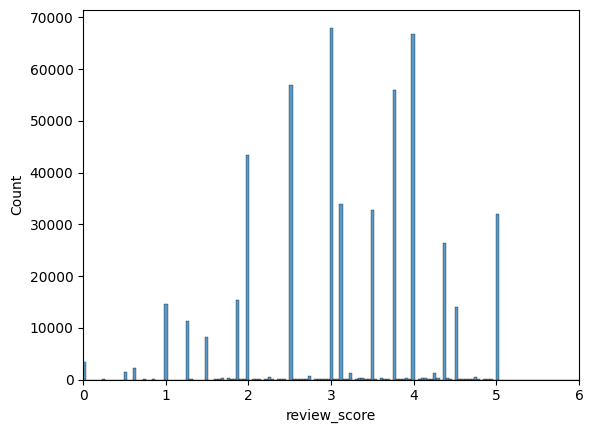

In [20]:
fig, ax = plt.subplots()
ax.set_xlim(0,6)
sns.histplot(df["review_score"], ax=ax)
plt.show()

Let us now add a column with name 'review_sentiment' with values 'Positiv' and 'Negative'

We define 'Positive' reviews to have standardized ratings of greater than 2.5 and 'Negative' otherwise.

In [21]:
def convert_rating_to_sentiment(rating: str):
    if rating >= 2.5:
        return "Positive"
    else:
        return "Negative"

In [22]:
df['review_sentiment'] = df['review_score'].apply(convert_rating_to_sentiment)

In [23]:
df.head(50)

,review_score,review_content,review_sentiment
3,3.500,Whether audiences will get behind The Lightnin...,Positive
6,1.250,Harry Potter knockoffs don't come more transpa...,Negative
7,3.500,"Percy Jackson isn't a great movie, but it's a ...",Positive
9,3.000,"Crammed with dragons, set-destroying fights an...",Positive
10,4.000,"This action-packed fantasy adventure, based on...",Positive
11,2.500,"For what it is and for whom it is intended, it...",Positive
12,2.000,Chris Columbus returns to his comfort zone for...,Negative
13,3.000,The best thing you can say about Chris Columbu...,Positive
15,3.500,"Percy Jackson may not be ""Harry Potter good,"" ...",Positive
17,3.125,"Admirably, the movie isn't bogged down in the ...",Positive


Now we know that the mapping is valid, we will drop the first column 'review_score'.

In [24]:
df.drop(columns = ['review_score'], inplace = True)

In [25]:
df.head(10)

,review_content,review_sentiment
3,Whether audiences will get behind The Lightnin...,Positive
6,Harry Potter knockoffs don't come more transpa...,Negative
7,"Percy Jackson isn't a great movie, but it's a ...",Positive
9,"Crammed with dragons, set-destroying fights an...",Positive
10,"This action-packed fantasy adventure, based on...",Positive
11,"For what it is and for whom it is intended, it...",Positive
12,Chris Columbus returns to his comfort zone for...,Negative
13,The best thing you can say about Chris Columbu...,Positive
15,"Percy Jackson may not be ""Harry Potter good,"" ...",Positive
17,"Admirably, the movie isn't bogged down in the ...",Positive


### Data Formatting

First, convert the review_sentiment column to a numerical variable. Where negative is assigned to 0 and positive is 1.

In [26]:
df["review_sentiment_num"] = df.review_sentiment.map({'Negative':0,'Positive':1})

# Check that the conversion worked
df.sample(23)

,review_content,review_sentiment,review_sentiment_num
145070,"The movie is clear, absorbing and argumentative.",Positive,1
82151,"It is far from being a biopic, more a cinemati...",Positive,1
1095440,"On TV, Everybody Loves Raymond. On the big scr...",Negative,0
921889,The need to belong drives the men behind a rev...,Positive,1
905361,A beautifully shot and made aquatic monster ho...,Positive,1
95617,It's too bad a similar level of thought didn't...,Negative,0
147692,The filmmakers employ a good measure of schmal...,Positive,1
106831,"A Wrinkle in Time, by and large, comes off as ...",Negative,0
1114156,If you don't feel more connected to your fello...,Positive,1
43809,The film has some memorable moments but overal...,Positive,1


## NLP Processing

Let us look at the proportion of our target variables: 0 and 1 (indicating negative and positive respectively).

C:\Users\ZANDREW GARAIS\AppData\Local\Temp\ipykernel_18568\3406610777.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_class=pd.value_counts(df["review_sentiment_num"], sort= True)


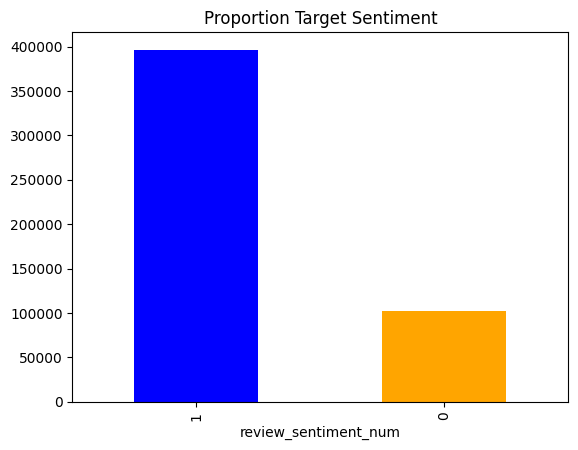

In [27]:
count_class=pd.value_counts(df["review_sentiment_num"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Sentiment')
plt.show()

We can see from the plot above that there is an imbalance in our data. review_sentiment_num = 1 overweighs 0.

In [28]:
print('Positive', round(df['review_sentiment'].value_counts()['Positive']/len(df) * 100), '%')
print('Negative', round(df['review_sentiment'].value_counts()['Negative']/len(df) * 100), '%')

Positive 80 %
Negative 20 %


Target class variable has an imbalance proportion, where "Positive" values more dominating with a proportion value of 54% while the "Negative" values are only 20%.

To handle the imbalanced data, we will perform oversampling. We will oversample the minority class using replacement. Let us first see the distribution of classes in the target.

In [29]:
df['review_sentiment_num'].value_counts()

review_sentiment_num
1    396467
0    102048
Name: count, dtype: int64

The minority class is review_sentiment_num = 0 with only 102048 value counts. Now, we will upsample the data so that the minority class matches the majority class.

In [30]:
from sklearn.utils import resample
#create two different dataframe of majority and minority class
df_majority = df[(df['review_sentiment_num']==1)]
df_minority = df[(df['review_sentiment_num']==0)]
# upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,    # sample with replacement
                                 n_samples= 396467, # to match majority class
                                 random_state=42)  # reproducible results
# Combine majority class with upsampled minority class
df = pd.concat([df_minority_upsampled, df_majority])

df['review_sentiment_num'].value_counts()

review_sentiment_num
0    396467
1    396467
Name: count, dtype: int64

After upsampling, the distribution of class is balanced as seen below.



C:\Users\ZANDREW GARAIS\AppData\Local\Temp\ipykernel_18568\3406610777.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_class=pd.value_counts(df["review_sentiment_num"], sort= True)


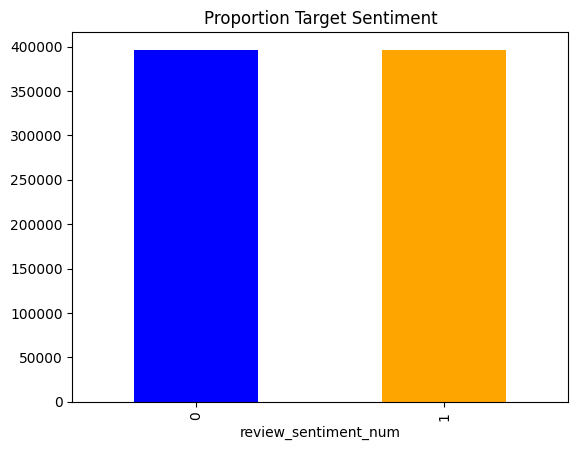

In [31]:
count_class=pd.value_counts(df["review_sentiment_num"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Sentiment')
plt.show()

### Common words

Let us now look at the most common words in each target variable. Starting with the positive reviews.

In [32]:
# Positive
count1 = Counter(" ".join(df[df['review_sentiment_num']== 1]['review_content']).\
                 split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)

df1 = df1.rename(columns={0: "common_words", 1 : "count"})
df1.head(10)

,common_words,count
0,the,368502
1,a,272725
2,and,264669
3,of,252346
4,to,172437
5,is,152251
6,in,112436
7,that,94924
8,it,75077
9,with,70270


In [33]:
# Negative
count2 = Counter(" ".join(df[df['review_sentiment_num']== 0]['review_content']).\
                 split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)

df2 = df2.rename(columns={0: "common_words", 1 : "count"})
df2.head(10)

,common_words,count
0,the,329288
1,a,249746
2,of,224027
3,and,204745
4,to,184131
5,is,138735
6,in,102893
7,that,92432
8,The,73190
9,it,69422


From the result above, most common words in target class variable contains so many stop words like "the, was, in, it, is" and etc. Which mean that the review_text still have untidy data. Before we go to the modelling steps we need to removing those all, and make the text become tidy data text.

### Tokenization

Let's tokenize our tweets first. We split the review_content by whitespaces and punctuation marks.



In [34]:
df["review_content (processed)"] = df["review_content"]

df["review_content (processed)"] = df["review_content (processed)"] \
    .transform(lambda text: re.split(r" |,|!|\.|\?|;|:", text))

df[["review_content", "review_content (processed)"]]

,review_content,review_content (processed)
129620,An aggressively crass - and not especially fun...,"[An, aggressively, crass, -, and, not, especia..."
5335,"They don't make thrillers like this any more, ...","[They, don't, make, thrillers, like, this, any..."
909679,Does this really tell us much that isn't paten...,"[Does, this, really, tell, us, much, that, isn..."
473042,It doesn't justify a seven-years-later return ...,"[It, doesn't, justify, a, seven-years-later, r..."
56921,"Like the criminals it portrays, Hostage is a d...","[Like, the, criminals, it, portrays, , Hostage..."
...,...,...
1130004,The movie is a revelation.,"[The, movie, is, a, revelation, ]"
1130005,"This is that rarity in films - an all-action, ...","[This, is, that, rarity, in, films, -, an, all..."
1130006,As a spectacular war film with a powerful mora...,"[As, a, spectacular, war, film, with, a, power..."
1130013,"Seen today, it's not only a startling indictme...","[Seen, today, , it's, not, only, a, startling,..."


Next, let's filter out empty tokens and non-alphanumeric characters.


In [35]:
df["review_content (processed)"] = df["review_content (processed)"] \
    .transform(
        lambda tokens: list(filter(lambda token: token.isalnum() and len(token) > 0, tokens))
    )

df[["review_content", "review_content (processed)"]]

,review_content,review_content (processed)
129620,An aggressively crass - and not especially fun...,"[An, aggressively, crass, and, not, especially..."
5335,"They don't make thrillers like this any more, ...","[They, make, thrillers, like, this, any, more,..."
909679,Does this really tell us much that isn't paten...,"[Does, this, really, tell, us, much, that, pat..."
473042,It doesn't justify a seven-years-later return ...,"[It, justify, a, return, of, a, once, horror, ..."
56921,"Like the criminals it portrays, Hostage is a d...","[Like, the, criminals, it, portrays, Hostage, ..."
...,...,...
1130004,The movie is a revelation.,"[The, movie, is, a, revelation]"
1130005,"This is that rarity in films - an all-action, ...","[This, is, that, rarity, in, films, an, straig..."
1130006,As a spectacular war film with a powerful mora...,"[As, a, spectacular, war, film, with, a, power..."
1130013,"Seen today, it's not only a startling indictme...","[Seen, today, not, only, a, startling, indictm..."


### To lowercase

Let us now change all uppercase tokens to lowercase.This is to have a better tally of the common words for each target variable.

In [36]:
df["review_content (processed)"] = df["review_content (processed)"] \
    .transform(lambda tokens: list(map(lambda token: token.lower(), tokens)))

df[["review_content", "review_content (processed)"]]

,review_content,review_content (processed)
129620,An aggressively crass - and not especially fun...,"[an, aggressively, crass, and, not, especially..."
5335,"They don't make thrillers like this any more, ...","[they, make, thrillers, like, this, any, more,..."
909679,Does this really tell us much that isn't paten...,"[does, this, really, tell, us, much, that, pat..."
473042,It doesn't justify a seven-years-later return ...,"[it, justify, a, return, of, a, once, horror, ..."
56921,"Like the criminals it portrays, Hostage is a d...","[like, the, criminals, it, portrays, hostage, ..."
...,...,...
1130004,The movie is a revelation.,"[the, movie, is, a, revelation]"
1130005,"This is that rarity in films - an all-action, ...","[this, is, that, rarity, in, films, an, straig..."
1130006,As a spectacular war film with a powerful mora...,"[as, a, spectacular, war, film, with, a, power..."
1130013,"Seen today, it's not only a startling indictme...","[seen, today, not, only, a, startling, indictm..."


We can see from the table above that we have successfully converted the review_content tokens to all lowercase letters. However, there are still stop words present.

### Stop words removal

Let's remove stop words from the review_content. For filtering out English stop words, we'll use the nltk package.

In [37]:
context_words = {"not", "no", "never", "none", "nothing", "neither", "nor", "nowhere", "nobody" , "not", "never", "hardly", "barely", "scarcely",
    "no", "none", "nothing", "nowhere", "nobody", "neither", "nor",
    "can't", "couldn't", "shouldn't", "wouldn't", "mustn't", "didn't", "haven't", "hadn't",
    "ain't", "shouldn't've",
    "barely there", "nowhere near", "by no means", "not at all", "not even", "not quite",
    "can't be", "couldn't be", "shouldn't be", "wouldn't be", "mustn't be", "didn't have", "haven't had",
    # Intensifiers:
    "very", "quite", "rather", "extremely", "really", "indeed", "absolutely", "totally", "utterly", "completely", "fully", "profoundly", "deeply", "significantly", "considerably", "substantially",
    "often", "frequently", "usually", "regularly", "constantly", "continually", "perpetually",
    "almost", "nearly", "about", "practically", "just about", "roughly", "approximately",
    "only", "just", "merely", "solely", "exclusively",
    "even", "even more", "even further", "still", "yet", "additionally", "furthermore",
    "a bit", "kind of", "sort of", "somewhat", "slightly", "a little", "barely", "marginally",
    "awfully", "dreadfully", "terribly", "incredibly", "unbelievably", "extraordinarily", "remarkably", "significantly", "substantially", "markedly", "notably", "considerably", "hugely", "immensely", "tremendously", "mightily", "deeply", "profoundly",
    "all the time", "constantly ever", "forever", "perpetually", "regularly", "repeatedly", "ceaselessly", "tirelessly",
    "just about", "pretty much", "practically", "roughly", "kind of", "sort of", "in a way", "to some extent",
    "precisely", "exactly", "right", "definitely", "absolutely", "unquestionably", "undeniable", "undoubtedly", "surely", "certainly",
    "indeed", "truly", "really", "genuinely", "sincerely", "honestly", "frankly", "simply", "merely", "plainly",
    "a tad", "a touch", "a smidge", "a sprinkle", "a bit of", "a shade", "a hint of", "barely", "marginally", "slightly", "somewhat"}

In [38]:
# Define negation words to retain

stopwords_set_english = set(stopwords.words("english"))

# Remove negation words from the stopwords set
stopwords_set_english -= context_words

df["review_content (processed)"] = df["review_content (processed)"] \
    .transform(
        lambda tokens: list(filter(lambda token: token not in stopwords_set_english, tokens))
    )

df[["review_content", "review_content (processed)", "review_sentiment_num"]]

,review_content,review_content (processed),review_sentiment_num
129620,An aggressively crass - and not especially fun...,"[aggressively, crass, not, especially, funny, ...",0
5335,"They don't make thrillers like this any more, ...","[make, thrillers, like, good, reason]",0
909679,Does this really tell us much that isn't paten...,"[really, tell, us, much, patently, obvious, an...",0
473042,It doesn't justify a seven-years-later return ...,"[justify, return, horror, franchise]",0
56921,"Like the criminals it portrays, Hostage is a d...","[like, criminals, portrays, hostage, dangerous...",0
...,...,...,...
1130004,The movie is a revelation.,"[movie, revelation]",1
1130005,"This is that rarity in films - an all-action, ...","[rarity, films, straightforward, heroic, momen...",1
1130006,As a spectacular war film with a powerful mora...,"[spectacular, war, film, powerful, moral, dime...",1
1130013,"Seen today, it's not only a startling indictme...","[seen, today, not, only, startling, indictment...",1


### Lemmatization

Next, we perform lemmatization on the text. Lemmatization is used to find the root form of words or lemmas in NLP. This helps save unnecessary computational overhead in deciphering entire words since most words’ meanings are well-expressed by their separate lemmas. We perform lemmatization using the WordNetLemmatizer() from nltk.

In [39]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer =  WordNetLemmatizer()

[nltk_data] Downloading package wordnet to C:\Users\ZANDREW
[nltk_data]     GARAIS\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [40]:
def lemma_line(words):
  lemmatizer = WordNetLemmatizer()
  lemmatized = [lemmatizer.lemmatize(word) for word in words]
  return lemmatized

In [41]:
df["review_content (processed)"] = df["review_content (processed)"].apply(lemma_line)
df[["review_content", "review_content (processed)"]]

,review_content,review_content (processed)
129620,An aggressively crass - and not especially fun...,"[aggressively, crass, not, especially, funny, ..."
5335,"They don't make thrillers like this any more, ...","[make, thriller, like, good, reason]"
909679,Does this really tell us much that isn't paten...,"[really, tell, u, much, patently, obvious, any..."
473042,It doesn't justify a seven-years-later return ...,"[justify, return, horror, franchise]"
56921,"Like the criminals it portrays, Hostage is a d...","[like, criminal, portrays, hostage, dangerous,..."
...,...,...
1130004,The movie is a revelation.,"[movie, revelation]"
1130005,"This is that rarity in films - an all-action, ...","[rarity, film, straightforward, heroic, moment..."
1130006,As a spectacular war film with a powerful mora...,"[spectacular, war, film, powerful, moral, dime..."
1130013,"Seen today, it's not only a startling indictme...","[seen, today, not, only, startling, indictment..."


We have now successfully lematized and removed stop words and punctuations from our review content. Let us now view the common words for each target variable again.

In [42]:
# Positive

positive_df = df[df["review_sentiment_num"] == 1]

all_tokens = [token for tokens in positive_df["review_content (processed)"] for token in tokens]

token_counts = Counter(all_tokens)

num_common = 10
common_words_list = token_counts.most_common(num_common)
common_words_positive = pd.DataFrame(common_words_list, columns=["common_words", "count"])
common_words_positive

,common_words,count
0,film,70324
1,movie,51038
2,not,34612
3,one,33550
4,about,27139
5,like,25287
6,story,24369
7,make,22725
8,performance,19230
9,just,17986


In [43]:
# Negative

negative_df = df[df["review_sentiment_num"] == 0]

all_tokens = [token for tokens in negative_df["review_content (processed)"] for token in tokens]

token_counts = Counter(all_tokens)

num_common = 10
common_words_list = token_counts.most_common(num_common)
common_words_negative = pd.DataFrame(common_words_list, columns=["common_words", "count"])
common_words_negative

,common_words,count
0,movie,58294
1,film,56431
2,not,36237
3,like,33337
4,one,30378
5,about,26188
6,just,23294
7,make,20727
8,no,20182
9,even,18820


We can see from the tables above that the common words for each target variable make more sense now. Let us visualize the results using a word cloud.

**Common words for Positive review_sentiment**

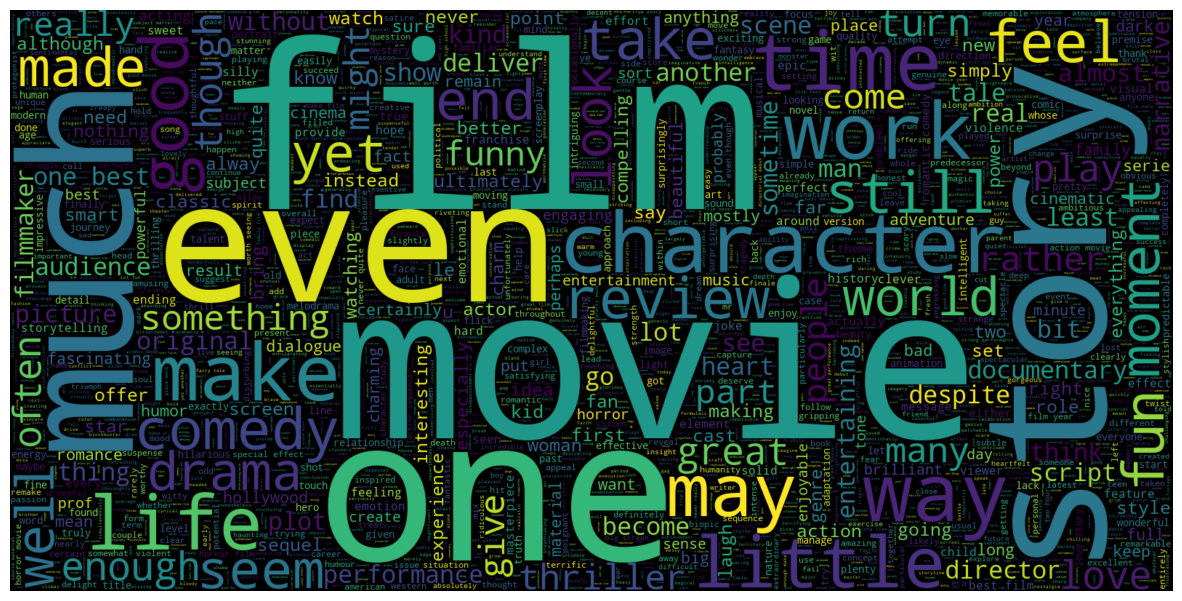

In [44]:
# Flatten the list of lists into a single list of tokens
tokens = [token for tokens_list in df[df.review_sentiment_num == 1]["review_content (processed)"] for token in tokens_list]

# Join the tokens into a single string
text = " ".join(tokens)

# Generate and plot the word cloud
plt.figure(figsize=(15, 15))
wc = WordCloud(width=1600, height=800, max_words=3000).generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()

**Common words for Negative review_sentiment**

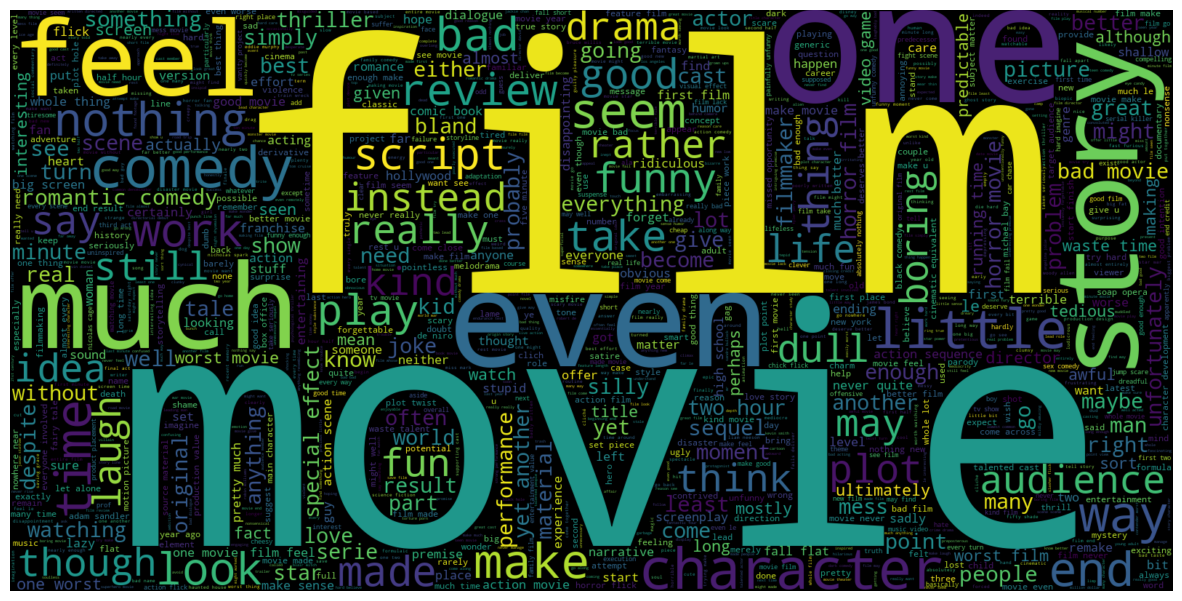

In [45]:
# Flatten the list of lists into a single list of tokens
tokens = [token for tokens_list in df[df.review_sentiment_num == 0]["review_content (processed)"] for token in tokens_list]

# Join the tokens into a single string
text = " ".join(tokens)

# Generate and plot the word cloud
plt.figure(figsize=(15, 15))
wc = WordCloud(width=1600, height=800, max_words=3000).generate(text)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.show()

# Vectorizing the dataset

Define X and y for use with TfIdfVectorizer. Let X be the review_content and y be the review_sentiment_num. But first we should convert the list of tokens in the review_content (processed) to a string to process training.

In [46]:
# Join the list of tokens into a single string
df["review_content (processed)"] = df["review_content (processed)"].apply(lambda tokens: ' '.join(tokens))

X = df["review_content (processed)"]
y = df.review_sentiment_num

# Compare sizes
print(X.shape)
print(y.shape)

(792934,)
(792934,)


Split X and y into training and testing sets.

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=427, stratify=y)

First, instatiate the TfIdf vectorizer with parameter ngram_range=(1, 2). This  defines the range of n-values for different n-grams to be extracted. An ngram_range of 1 to 2 is chosen because we want to capture the context of words in a sentence.

In [48]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect =  TfidfVectorizer(ngram_range=(1,2))

Then, learn training data vocabulary and examine.

In [49]:
vect.fit(X_train)
vect.get_feature_names_out()


array(['00', '00 106', '00 mark', ..., 'όποια ελπίδα', 'ﬁlm', 'ﬁlm offer'],
      dtype=object)

In [50]:
length_of_feature_names = len(vect.get_feature_names_out())
print("Length of feature names:", length_of_feature_names)

Length of feature names: 2291431


Transform data into a document-term matrix.

In [51]:
X_train_dtm = vect.transform(X_train)

In [52]:
X_train_dtm = vect.fit_transform(X_train)

In [53]:
# Get the first 50 feature names
feature_names_subset = vect.get_feature_names_out()[:50]

# Get the corresponding subset of the document-term matrix
X_train_dtm_subset = X_train_dtm[:, :50]

# Convert the subset of the document-term matrix to DataFrame
dtm_subset_df = pd.DataFrame(X_train_dtm_subset.toarray(), columns=feature_names_subset)

# Display the subset of the DataFrame
print(dtm_subset_df)

         00  00 106  00 mark  00 parking  00 see  00 ticket  00 video  000  \
0       0.0     0.0      0.0         0.0     0.0        0.0       0.0  0.0   
1       0.0     0.0      0.0         0.0     0.0        0.0       0.0  0.0   
2       0.0     0.0      0.0         0.0     0.0        0.0       0.0  0.0   
3       0.0     0.0      0.0         0.0     0.0        0.0       0.0  0.0   
4       0.0     0.0      0.0         0.0     0.0        0.0       0.0  0.0   
...     ...     ...      ...         ...     ...        ...       ...  ...   
594695  0.0     0.0      0.0         0.0     0.0        0.0       0.0  0.0   
594696  0.0     0.0      0.0         0.0     0.0        0.0       0.0  0.0   
594697  0.0     0.0      0.0         0.0     0.0        0.0       0.0  0.0   
594698  0.0     0.0      0.0         0.0     0.0        0.0       0.0  0.0   
594699  0.0     0.0      0.0         0.0     0.0        0.0       0.0  0.0   

        000 000  000 actually  ...  000 fold  000 foot  000 for

Transform the testing data into a document-term matrix as well.

In [54]:
X_test_dtm = vect.transform(X_test)

# Building the Model (Multinomial Naive Bayes Classifier)

In [55]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

Train the model using X_train_dtm and the fit() method.

## Applying Multinomial Naive Bayes

In [56]:
nb.fit(X_train_dtm, y_train)

MultinomialNB()

Make sentiment prediction for X_test_dtm using the predict() function.

In [57]:
y_pred_class = nb.predict(X_test_dtm)

**Matrix Evaluation**

Let us get the accuracy of our test set.

In [58]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.8744463613709051

In [59]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[95703,  3414],
       [21475, 77642]], dtype=int64)

In [60]:
# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class, digits=4))

              precision    recall  f1-score   support

           0     0.8167    0.9656    0.8849     99117
           1     0.9579    0.7833    0.8619     99117

    accuracy                         0.8744    198234
   macro avg     0.8873    0.8744    0.8734    198234
weighted avg     0.8873    0.8744    0.8734    198234



Comparing the accuracy score of our train dataset and test dataset.

In [61]:
predict_train = nb.fit(X_train_dtm, y_train).predict(X_train_dtm)

# Accuracy Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)


# predict the target on the test dataset
predict_test = nb.predict(X_test_dtm)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on train dataset :  0.9514343366403228
accuracy_score on test dataset :  0.8744463613709051


A visual representation of the confusion matrix.

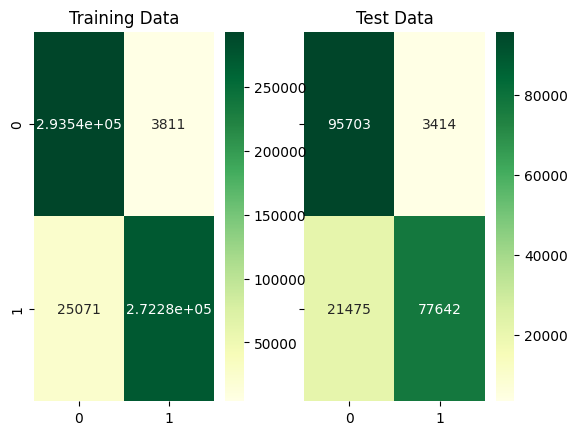

In [62]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,predict_train)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,predict_test)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

## Examining the model for further insight

We will examine the our **trained Naive Bayes model** to calculate the approximate **"positivity"** of each token.

In [63]:
# store the vocabulary of X_train using get_feature_names_out()
# its length should be 161925
X_train_tokens = vect.get_feature_names_out()
print(len(X_train_tokens))

2291431


In [64]:
# examine the first 50 tokens
print(X_train_tokens[0:50])

['00' '00 106' '00 mark' '00 parking' '00 see' '00 ticket' '00 video'
 '000' '000 000' '000 actually' '000 años' '000 bad' '000 bc'
 '000 beheading' '000 belle' '000 belongs' '000 boat' '000 borrows'
 '000 budget' '000 building' '000 cg' '000 coach' '000 corps' '000 could'
 '000 countryman' '000 curio' '000 day' '000 death' '000 donor' '000 duck'
 '000 extra' '000 extravagant' '000 factor' '000 fangoria' '000 fathom'
 '000 fellow' '000 filled' '000 film' '000 finger' '000 firecracker'
 '000 fold' '000 foot' '000 former' '000 frame' '000 french' '000 ft'
 '000 funny' '000 gallon' '000 good' '000 horsepower']


In [65]:
# examine the last 50 tokens
print(X_train_tokens[-50:])

['último segundo' 'último trabalho' 'últimos' 'últimos 45' 'últimos ano'
 'últimos dez' 'últimos péssimos' 'últimos tempo' 'única' 'única cena'
 'única forma' 'única razón' 'único' 'único atrativo' 'único longa'
 'único momento' 'único problema' 'único que' 'únicos' 'únicos atrativos'
 'über' 'über unrealistc' 'übermensch' 'übermensch philosophy' 'će'
 'će gledateljima' 'će popriličnu' 'će se' 'će za' 'čini'
 'čini gledljivim' 'čini iznad' 'żabińska' 'żabińska jan' 'żabiński'
 'żabiński courageous' 'żabiński downright' 'żabińskis' 'żabińskis lack'
 'για' 'για σοβαρή' 'δράση' 'ελπίδα' 'ελπίδα για' 'σοβαρή' 'σοβαρή δράση'
 'όποια' 'όποια ελπίδα' 'ﬁlm' 'ﬁlm offer']


In [66]:
# Naive Bayes counts the number of times each token appears in each class
nb.feature_count_

array([[3.30758228, 0.        , 0.        , ..., 0.66666667, 1.16530553,
        1.16530553],
       [1.08577327, 0.48249799, 0.28392491, ..., 0.        , 0.        ,
        0.        ]])

In [67]:
# rows represent classes, columns represent tokens
nb.feature_count_.shape

(2, 2291431)

In [68]:
# number of times each token appears across all negative sentiment review
negative_token_count = nb.feature_count_[0, :]
negative_token_count

array([3.30758228, 0.        , 0.        , ..., 0.66666667, 1.16530553,
       1.16530553])

In [69]:
# number of times each token appears across all neutral sentiment review
neutral_token_count = nb.feature_count_[1, :]
neutral_token_count

array([1.08577327, 0.48249799, 0.28392491, ..., 0.        , 0.        ,
       0.        ])

In [70]:
# number of times each token appears across all positive sentiment review
positive_token_count = nb.feature_count_[1, :]
positive_token_count

array([1.08577327, 0.48249799, 0.28392491, ..., 0.        , 0.        ,
       0.        ])

In [71]:
# create a DataFrame of tokens with their separate positive, neutral, and negative counts
tokens = pd.DataFrame({'token':X_train_tokens, 'negative':negative_token_count, 'positive':positive_token_count }).set_index('token')

In [72]:
# examine 5 random DataFrame rows using the sample() method
tokens.sample(5, random_state=427)

,negative,positive
token,,
vivacity rakish,0.000000,0.205556
acting favour,0.000000,0.238346
hidden amongst,0.000000,0.449823
cancer aid,1.285143,0.000000
spielberg older,0.000000,0.226210


In [73]:
# Naive Bayes counts the number of observations in each class
nb.class_count_

array([297350., 297350.])

Before we can calculate the "positiveness" of each token, we need to avoid dividing by zero and account for the class imbalance.

In [74]:
tokens['negative'] += 1
tokens['positive'] += 1
tokens.sample(5, random_state=427)

,negative,positive
token,,
vivacity rakish,1.000000,1.205556
acting favour,1.000000,1.238346
hidden amongst,1.000000,1.449823
cancer aid,2.285143,1.000000
spielberg older,1.000000,1.226210


In [75]:
# convert the positive, netural, and negative counts into frequencies
# by dividing them with nb.class_count_
tokens['negative'] = tokens.negative / nb.class_count_[0]
tokens['positive'] = tokens.positive / nb.class_count_[1]
tokens.sample(5, random_state=427)

,negative,positive
token,,
vivacity rakish,0.000003,0.000004
acting favour,0.000003,0.000004
hidden amongst,0.000003,0.000005
cancer aid,0.000008,0.000003
spielberg older,0.000003,0.000004


In [76]:
# calculate the ratio of positive-to-neutral-and-negative for each token
tokens['positive_ratio'] = tokens.positive / tokens.negative

tokens.sample(5, random_state=427)

,negative,positive,positive_ratio
token,,,
vivacity rakish,0.000003,0.000004,1.205556
acting favour,0.000003,0.000004,1.238346
hidden amongst,0.000003,0.000005,1.449823
cancer aid,0.000008,0.000003,0.437609
spielberg older,0.000003,0.000004,1.226210


In [77]:
# examine the DataFrame sorted by spam_ratio
tokens.sort_values('positive_ratio', ascending=False)

,negative,positive,positive_ratio
token,,,
powerful film,0.000003,0.000125,37.144522
thoroughly entertaining,0.000003,0.000098,29.097376
hugely enjoyable,0.000003,0.000090,26.827842
despite flaw,0.000003,0.000089,26.563567
observant,0.000004,0.000103,25.628451
...,...,...,...
unfunny comedy,0.000178,0.000008,0.045930
unfunny,0.001359,0.000059,0.043741
contender worst,0.000113,0.000005,0.042357


Let us now proceed to creating our first model!

## Hyperparameter tuning

We will perform hyperparameter tuning using RandomizedSearchCV. This helps optimize the Naive Bayes model by finding the best hyperparameter settings to improve its performance.

In [78]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the distribution of hyperparameters
param_dist = {
    'alpha': uniform(0.01, 10)
}

# Set up the randomized search
random_search = RandomizedSearchCV(nb, param_dist, n_iter=100, cv=5, n_jobs=-1, verbose=1, random_state=42)

# Fit the model
random_search.fit(X_train_dtm, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'alpha': 0.06522117123602399}


In [79]:
# Train the final model with the best hyperparameters
best_mnb = MultinomialNB(alpha=best_params['alpha'])
best_mnb.fit(X_train_dtm, y_train)

# Predict on the test set
y_pred = best_mnb.predict(X_test_dtm)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Test set accuracy: ", accuracy)
print("Classification report: \n", report)


Test set accuracy:  0.9060907816015417
Classification report: 
               precision    recall  f1-score   support

           0       0.86      0.97      0.91     99117
           1       0.97      0.84      0.90     99117

    accuracy                           0.91    198234
   macro avg       0.91      0.91      0.91    198234
weighted avg       0.91      0.91      0.91    198234



We can see the we have improved the accuracy of our test set using the best parameter.

## Download the Multinomial Naive Bayes model

Finally, let us download the model with the best perfomance, the tuned model.

In [80]:
# # save the model to a file
joblib.dump(nb, 'multinomial_nb_model.joblib')

['multinomial_nb_model.joblib']

In [81]:
joblib.dump(vect, 'vectorizer.pkl')

['vectorizer.pkl']

# Building the model (Logistic Regression)

## Applying Logistic Regression

In [82]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter = 5000)

Initializing the model using the L2 regularization

In [83]:
lr.fit(X_train_dtm, y_train)

LogisticRegression(max_iter=5000)

In [84]:
y_pred_class = lr.predict(X_test_dtm)

### Model Accuracy


In [85]:
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.8628842680872101

In [86]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[89928,  9189],
       [17992, 81125]], dtype=int64)

In [87]:
# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_class, digits=4))

              precision    recall  f1-score   support

           0     0.8333    0.9073    0.8687     99117
           1     0.8983    0.8185    0.8565     99117

    accuracy                         0.8629    198234
   macro avg     0.8658    0.8629    0.8626    198234
weighted avg     0.8658    0.8629    0.8626    198234



Comparing the accuracy score of our train dataset and test dataset.

In [88]:
predict_train = lr.fit(X_train_dtm, y_train).predict(X_train_dtm)

# Accuracy Score on train dataset
accuracy_train = accuracy_score(y_train,predict_train)
print('accuracy_score on train dataset : ', accuracy_train)


# predict the target on the test dataset
predict_test = lr.predict(X_test_dtm)

# Accuracy Score on test dataset
accuracy_test = accuracy_score(y_test,predict_test)
print('accuracy_score on test dataset : ', accuracy_test)

accuracy_score on train dataset :  0.9224398856566336
accuracy_score on test dataset :  0.8628842680872101


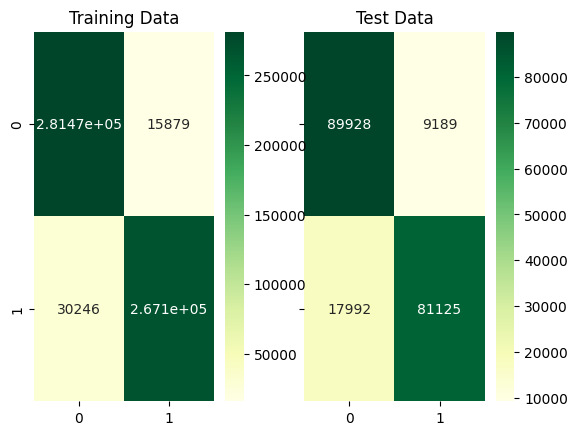

In [89]:
from sklearn import metrics
f,a =  plt.subplots(1,2,sharex=True,sharey=True,squeeze=False)

#Plotting confusion matrix for the different models for the Training Data

plot_0 = sns.heatmap((metrics.confusion_matrix(y_train,predict_train)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][0]);
a[0][0].set_title('Training Data')

plot_1 = sns.heatmap((metrics.confusion_matrix(y_test,predict_test)),annot=True,fmt='.5g',cmap="YlGn",ax=a[0][1]);
a[0][1].set_title('Test Data');

## Hyperparameter Tuning

Hyperparameter tuning will be conducted using RandomizedSearchCV over the following parameters:

In [90]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the distribution of hyperparameters
param_dist = {
    'C': [0.01, 0.1, 1, 10, 100]
}

# Set up the randomized search
random_search = RandomizedSearchCV(lr, param_dist, n_iter=10, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Fit the model
random_search.fit(X_train_dtm, y_train)

# Get the best parameters
best_params = random_search.best_params_
print("Best parameters found: ", best_params)


C:\Program Files\Python312\Lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters found:  {'C': 100}


### Get the optimal Model

In [93]:
# Train the final model with the best hyperparameters
best_lr = LogisticRegression(C=best_params['C'])
best_lr.fit(X_train_dtm, y_train)

# Predict on the test set
y_pred = best_lr.predict(X_test_dtm)

# Evaluate the model
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Test set accuracy: ", accuracy)
print("Classification report: \n", report)

C:\Program Files\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test set accuracy:  0.9248060373094423
Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.98      0.93     99117
           1       0.97      0.87      0.92     99117

    accuracy                           0.92    198234
   macro avg       0.93      0.92      0.92    198234
weighted avg       0.93      0.92      0.92    198234



## Download the Optimal Logistic Regression Model

In [94]:
joblib.dump(best_lr, 'log_reg_model.joblib')

['log_reg_model.joblib']